In [2]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import cv2
import math
from skimage.io import imread
from tifffile import TiffFile
plt.rcParams["font.family"] = "Times New Roman"

In [3]:
def read_image_voxel_size(file_path):

    """
    Extracts pixel scaling from tiff meta data.

    Parameters:
    - file_path: path to the tif image. 
    
    Returns:
    - A list containing the pixel scalings in all three dimensions.
    """

    def _xy_voxel_size(tags, key):
        assert key in ['XResolution', 'YResolution']
        if key in tags:
            num_pixels, units = tags[key].value
            return units / num_pixels
        # return default
        return 1.

    with TiffFile(file_path) as tiff:
        image_metadata = tiff.imagej_metadata
        if image_metadata is not None:
            z = image_metadata.get('spacing', 1.)
        else:
            # default voxel size
            z = 1.

        tags = tiff.pages[0].tags
        # parse X, Y resolution
        y = _xy_voxel_size(tags, 'YResolution')
        x = _xy_voxel_size(tags, 'XResolution')
        # return voxel size
        return [z, x, y]

In [4]:
def analyze_pixel_values(image, angles):
    """
    Analyze pixel values in an image at predefined angles starting from the center.

    Parameters:
    - image: A 2D NumPy array representing the image.
    - angles: A list of angles in degrees at which pixel values should be analyzed.

    Returns:
    - results: A list containing the analyzed pixel values for each angle.
    """
    results = []

    # Get image dimensions
    height, width = image.shape

    # Calculate the center of the image
    center_x, center_y = width // 2, height // 2

    # Iterate through predefined angles
    for angle in angles:
        # Convert angle to radians
        radian_angle = math.radians(angle)

        # Calculate coordinates for the line starting from the center
        x_end = int(center_x + 0.495 * width * math.cos(radian_angle))
        y_end = int(center_y + 0.495 * height * math.sin(radian_angle))

        x_begin = int(center_x - 0.495 * width * math.cos(radian_angle))
        y_begin = int(center_y - 0.495 * height * math.sin(radian_angle))

        

        # Use Bresenham's line algorithm to get pixel values along the line
        line_x, line_y = np.linspace(x_begin, x_end, num=width), np.linspace(y_begin, y_end, num=height)
        
        # Round the coordinates to the nearest integers
        line_x, line_y = np.round(line_x).astype(int), np.round(line_y).astype(int)

        # Ensure that coordinates are within bounds
        line_x = np.clip(line_x, 0, width - 1)
        line_y = np.clip(line_y, 0, height - 1)

        # Extract the pixel values at rounded coordinates
        pixel_values = image[line_y, line_x]

        # Store the result for the current angle
        results.append(pixel_values)

    return results


In [5]:
def plot_integral_values(results, angles, ax , label):
    """
    Calculate the integral of pixel values per angle and plot it against the angle.

    Parameters:
    - results: A list containing the analyzed pixel values for each angle.
    - angles: A list of angles in degrees.

    Returns:
    - None (displays the plot).
    """
    integral_values = np.array([np.sum(np.cumsum(values))/len(values) for values in results])

    # Plot the integral values against the angles
    ax.plot(angles, integral_values/np.mean(integral_values)
            , marker='o'
            , label = label
            , alpha = 0.25
            , markeredgecolor = 'w'
            , color = (166/255,166/255,192/255)
            , markersize = 3
            )
#     ax.set_title('Integral of Pixel Values vs. Angle')
#     ax.set_xlabel('Angle (degrees)')
#     ax.set_ylabel('Integral of Pixel Values')
    ax.grid(False)
    return ax 


In [6]:

def plot_lines_on_image(image, angles):
    """
    Plot lines on the image corresponding to the predefined angles.

    Parameters:
    - image: A 2D NumPy array representing the image.
    - angles: A list of angles in degrees.

    Returns:
    - None (displays the image with lines).
    """
    fig2,ax2 = plt.subplots(figsize = (4.6,4.6))
    # Make a copy of the image to avoid modifying the original
    image_with_lines = np.copy(image)

    # Get image dimensions
    height, width = image.shape

    # Calculate the center of the image
    center_x, center_y = width // 2, height // 2

    # Iterate through predefined angles
    for angle in angles:
        # Convert angle to radians
        radian_angle = math.radians(angle)

        # Calculate coordinates for the line starting from the center
        x_end = int(center_x + 0.49 * width * math.cos(radian_angle))
        y_end = int(center_y + 0.49 * height * math.sin(radian_angle))
        
        x_begin = int(center_x - 0.49 * width * math.cos(radian_angle))
        y_begin = int(center_y - 0.49 * height * math.sin(radian_angle))

        
        # Draw the line on the image
        # cv2.line(image_with_lines, (x_begin, y_begin), (x_end, y_end), (255, 255, 0), 2)

    # Display the image with lines
    im = ax2.imshow(image_with_lines/np.mean(image_with_lines), cmap = 'plasma')
    cb = fig2.colorbar(im, ax=ax2,orientation='horizontal',location="bottom",fraction=0.046, pad=0.04)
    cb.set_label('FT magnitude (a.u.)', fontsize = 20)
    cb.outline.set_linewidth(1.5)
    for t in cb.ax.get_xticklabels():
     t.set_fontsize(17)

    # plt.title('Lines on Image')
    plt.axis('off')
    return fig2 ,ax2, cb 

['FFT_Pombe_766_CF002-1.tif' 'FFT_Pombe_766_CF002-2.tif'
 'FFT_Pombe_767_CF004-1.tif' 'FFT_Pombe_767_CF004-2.tif'
 'FFT_Pombe_767_CF005-1.tif' 'FFT_Pombe_767_CF005-2.tif']
FFT_Pombe_766_CF002-1.tif
FFT_Pombe_766_CF002-2.tif
FFT_Pombe_767_CF004-1.tif
FFT_Pombe_767_CF004-2.tif
FFT_Pombe_767_CF005-1.tif
FFT_Pombe_767_CF005-2.tif


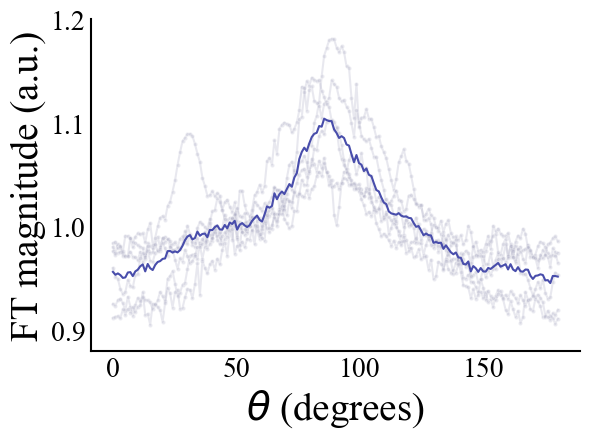

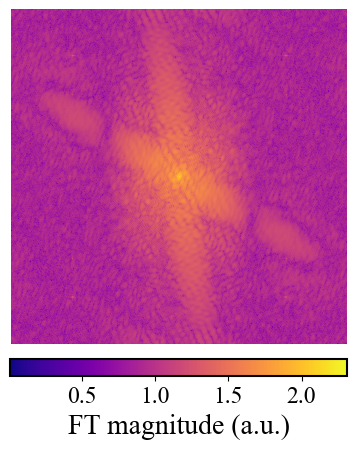

In [8]:
from scipy.stats import binned_statistic
from scipy.signal import find_peaks


ffts = np.sort(glob("FFT*.tif"))[4:]
images =np.sort([f for f in  glob("*.tif") if 'FFT' not in f])



fig,ax =plt.subplots(figsize = (6,4.5))
s = 180

accumulation = np.zeros((len(ffts),s))

for k, i in enumerate(ffts):
    image = imread(i)
    
    # Define angles at which to analyze pixel values
    angles_to_analyze = np.linspace(0,180 ,s)

    # Call the function
    results = analyze_pixel_values(image, angles_to_analyze)
    if k == 4:
        fig2, ax2 , cb = plot_lines_on_image(image, angles_to_analyze)

    ax = plot_integral_values(results, angles_to_analyze,ax = ax , label= i)

    vals = np.array([np.sum(np.cumsum(values))/len(values) for values in results])
    accumulation[k, :] =vals/np.mean(vals)


ax.plot(angles_to_analyze, np.mean(accumulation, axis = 0), color = (72/255,77/255,171/255), marker = '', markeredgecolor = 'w' ,markersize = 4)
# peaks, _ = find_peaks(h, height=1.)

ax.set_xlabel('$\\theta$ (degrees)', fontsize = 28)
ax.set_ylabel('FT magnitude (a.u.)', fontsize = 28)

ax.set_ylim(0.88, 1.2)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=20, length = 0)
ax.tick_params(axis='both', which='minor', labelsize=8)


fig.tight_layout()
fig2.tight_layout()

fig.savefig('angular_fft.svg')
fig2.savefig('fourier_spectrum.svg')